# 強化学習（Q学習とQ-Network）によるCart Pole制御

---

## 目的
強化学習を用いてCart Pole制御を学習する．
Cart Pole制御とは，Cartに乗っているPoleが倒れないように台車を左右に動かすことである．

Q-Tableを用いた従来のQ学習による方法と，Q-Networkを用いた方法の２種類を行う．

## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

### モジュールの追加インストール
下記のプログラムを実行して，実験結果の表示に必要な追加ライブラリやモジュールをインストールする．

In [1]:
!pip install swig==4.3.0
!pip install gymnasium==1.0.0
!pip install gym==0.23.1

!apt update && apt install xvfb
!pip install gym-notebook-wrapper==1.3.3

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

## モジュールのインポート
はじめに必要なモジュールをインポートする．

今回はPyTorchに加えて，Cart Poleを実行するためのシミュレータであるOpenAI Gym（gym）をインポートする．

In [2]:
import numpy as np
import gym
import gym.spaces

import time
import datetime
import random
import matplotlib
import matplotlib.pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Use CUDA: True


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## シード値の固定

In [3]:
seed = 123
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# Q学習 (Q-table)
Q学習とは，TD法を用いた代表的な手法の一つです．
最適な行動価値（Q値）を推定するように学習を行い，Q値を行動の指針として用いることで最適な行動を行います．\
Q学習では，全ての状態$s$と行動$a$に対する価値$Q(s, a)$を記録するテーブル(Q-table) を作成します．
しかし，学習初期の段階では，各状態と行動に対する正確な行動価値が分からないため，Q-tableを任意の値に初期化します．
その後，様々な状態の下で実際に行動を選択し，推定した行動価値を用いてQ-tableを修正していきます．
以下に，簡略化したQ学習の流れを記載します．
1. ある環境における全ての状態と行動に対する価値（Q値）を記録するためのQ-tableを作成
2. Q-tableに記録されたQ値を任意の値で初期化
3. $\epsilon$-greedy法などを用いて環境に対する行動を選択
4. 選択した行動に対する報酬値とQ-tableに記録されたQ値をもとに，Q-tableを更新
5. 最適なQ-tableが完成するまで3,4を繰り返す

## 環境の作成
今回の実験で使用する環境の作成を行います． [OpenAI Gym](https://gymnasium.farama.org/) は，様々な種類の環境を提供しているモジュールです．

今回の実験では，gymで利用できる[CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)を使用します．(今回はCartPole-v1)\
まず，gym.make関数で使用したい環境を指定します．
その後，reset関数を用いて環境を初期化し，環境に対する情報を確認します．

CartPoleは，Cartに乗ったPoleを倒さないようにCartを制御するという環境です．環境における行動は，Cartを右か左に動かすという離散的な行動をもち，状態は連続的な値で表されたCart位置，Cart速度，Poleの角度，Poleの角速度からなる状態を持っています．

In [4]:
env = gym.make('CartPole-v1')

obs = env.reset(seed=seed)
print('observation space:',env.observation_space)
print('action space:',env.action_space)
print('initial observation',obs)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
initial observation [ 0.01823519 -0.0446179  -0.02796401 -0.03156282]


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

## Q-tableの作成，離散化処理
Q-tableの作成とCartPole環境における状態の離散化処理を行います．

Q学習は，Q-tableを用いた学習を行います．しかし，今回使用する環境であるCartPoleは，Cart位置，Cart速度，Poleの角度，Poleの角速度からなる4次元の状態をもっており，それぞれ以下の範囲で連続的な値をとります．

- Cart位置：-4.8 ～ 4.8（-2.4〜2.4の範囲外になるとエピソードが終了となる）
- Cart速度：-Inf ～ Inf
- Poleの角度：-0.41 ～ 0.41
- Poleの角速度：-Inf ～ Inf

Q学習では，任意の大きさのQ-tableを作成しなければいけないため，連続的な数値ではQ-tableを作成することができません．そのため，状態を分割し，離散的な値に変換することでQ-tableを作成可能とします．

今回は，numpyのdigitize関数とlinspace関数を組み合わせて，離散化処理を行います． \
まず，linspace関数を用いて，分割数に応じて状態の範囲を区切ります．そして，dizitize関数で，ある値が区切られた範囲でどこの区画に属するのかを返します．これにより，連続的な数値であっても，その値がどの区画なのかという数値に変換されるため，離散化された値とすることができます．

状態の離散化により，環境における状態数が決定されるため，決定した状態数の大きさに合わせたQ-tableを作成します．\
はじめに，決定した状態の分割数$x$により，離散化する際の値が変化し，Q-tableの大きさが変化します．CartPoleは，4次元の状態を持っているため，Q-tableの大きさは$x^4(状態数)×2(actionの数)$となります．

In [5]:
num_dizitized = 10  # 状態の分割数

def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

# 各値を離散値に変換
def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, num_dizitized)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, num_dizitized)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, num_dizitized)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, num_dizitized))
    ]
    return sum([x * (num_dizitized**i) for i, x in enumerate(digitized)])

q_table = np.random.uniform(low=-1, high=1, size=(num_dizitized**4, env.action_space.n))

## アクションの選択 ($\epsilon$-greedy法)
アクションの選択方法として，$\epsilon$-greedy法を用いた行動選択の定義を行います．

Q学習では，Q値をもとに行動選択を行いますが，Q値が大きい行動のみをとり続けることは，局所解へ陥ってしまう問題につながります．
そのため，環境の適度な探索と，学習によって得られた知見を活用した行動のバランスが重要となります．
この問題を，探索と利用のトレードオフと呼び，強化学習での大きな課題の一つとなっています．

$\epsilon$-greedy法は，適度な探索を行う手法であり，確率$\epsilon$でQ値が最も大きい行動を選択し，確率$1-\epsilon$で，ランダムな行動を選択するといった手法です．

In [6]:
def get_action_q(next_state, episode, epsilon):
    if epsilon <= np.random.uniform(0, 1):
        next_action = np.argmax(q_table[next_state])
    else:
        next_action = np.random.choice([0, 1])
    return next_action

## Qテーブルの更新
Q-tableの更新関数を定義します．\
Q学習は，報酬と行動価値をもとに最適なQ-tableを推定していく手法であり，Q-tableの更新にはTD法を用いた更新を行います．
ある状態におけるある行動の価値を，次状態における最良の行動価値に近似するように更新を行っていきます．
Q値の更新式としては以下の式となります．

$$
Q(s,a)←Q(s,a)+\alpha(r+\gamma \max_{a'}Q(s',a')-Q(s,a))
$$
また，次式のように表すこともできます．
$$
Q(s,a)←(1-\alpha)Q(s,a)+\alpha(r+\gamma \max_{a'}Q(s',a'))
$$

この更新式を用いて，Q-tableの更新を行っていきます．あらゆる状態を経験することにより，最適なQ-tableが作成されます．


In [7]:
def update_Qtable(q_table, state, action, reward, next_state):
    alpha = 0.5
    next_Max_Q=max(q_table[next_state][0],q_table[next_state][1] )
    q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + GAMMA * next_Max_Q)
    return q_table

## 学習に必要な各種パラメータ設定
今回の実験に使用する各種パラメータの設定を行います．ここでは，学習における総試行回数などの学習で必要なパラメータの設定を行っています．

In [8]:
max_number_of_steps = 200  # 1試行のstep数
num_consecutive_iterations = 100  # 学習完了評価に使用する平均試行回数
num_episodes = 1000  # 総試行回数
total_reward_vec = np.array([])  # 各試行の報酬を格納

EPSILON = 0.02 # ε-greedy法のε
GAMMA = 0.99 # 割引率

## Q学習メインプログラム
Q学習のメイン関数です．
ここまでの設定に従い，Q学習を用いて学習を行います．
以下のような流れのプログラムを作成します．
1. 環境の初期化・状態の離散化を行い，初期状態を獲得
2. 獲得した状態から行動を選択（$\epsilon$-greedy法を用いた行動選択）
3. 環境に対してエージェントが行動（遷移情報の獲得）
4. 得られた経験を用いてQ-tableを更新
5. 指定したステップ数，2～4を繰り返す

In [9]:
# グラフ描画用の配列
record_episode = []
record_reward = []

ts = time.time()
for episode in range(num_episodes):  # 試行数分繰り返す
    # 環境の初期化
    observation = env.reset(seed=seed)
    state = digitize_state(observation)
    action = np.argmax(q_table[state])
    episode_reward = 0

    for t in range(max_number_of_steps):  # 1試行のループ
        observation, reward, done, info = env.step(action)

        # 報酬設計
        if done:
            if t < 195:
                reward = -200  # 倒れたら罰則
            else:
                reward = 1  # 立ったまま終了時は罰則はなし
        else:
            reward = 1  # 各ステップで立ってたら報酬追加

        episode_reward += reward  # 報酬を追加

        # Q-tableを更新する
        next_state = digitize_state(observation)  # 観測状態を離散値に変換
        q_table = update_Qtable(q_table, state, action, reward, next_state)

        #  行動を選択
        action = get_action_q(next_state, episode, EPSILON)

        state = next_state

        # 終了時の処理
        if done:
            total_reward_vec = np.append(total_reward_vec, episode_reward)  # 報酬を記録
            record_reward.append(total_reward_vec[-100:].mean()) # グラフ描画用に記録
            record_episode.append(episode+1)
            if (episode+1)%10==0:
              print('Episode {0}: {1} steps, reward {2}, mean reward {3:.3f}, time {4}'.format(episode+1, t+1, episode_reward, total_reward_vec[-100:].mean(), datetime.timedelta(seconds = time.time() - ts)))
            break

Episode 10: 35 steps, reward -166, mean reward -183.400, time 0:00:00.036125
Episode 20: 37 steps, reward -164, mean reward -176.700, time 0:00:00.076412
Episode 30: 18 steps, reward -183, mean reward -176.733, time 0:00:00.100966
Episode 40: 35 steps, reward -166, mean reward -177.050, time 0:00:00.123866
Episode 50: 38 steps, reward -163, mean reward -176.980, time 0:00:00.149876
Episode 60: 36 steps, reward -165, mean reward -174.867, time 0:00:00.198045
Episode 70: 54 steps, reward -147, mean reward -171.529, time 0:00:00.247707
Episode 80: 57 steps, reward -144, mean reward -167.975, time 0:00:00.311442
Episode 90: 122 steps, reward -79, mean reward -163.944, time 0:00:00.374008
Episode 100: 152 steps, reward -49, mean reward -155.010, time 0:00:00.551670
Episode 110: 123 steps, reward -78, mean reward -145.640, time 0:00:00.678119
Episode 120: 109 steps, reward -92, mean reward -136.350, time 0:00:00.806380
Episode 130: 43 steps, reward -158, mean reward -127.830, time 0:00:00.91

## 学習時の平均スコアの推移
横軸エピソード数，縦軸平均スコアとしたグラフを描画してみます．


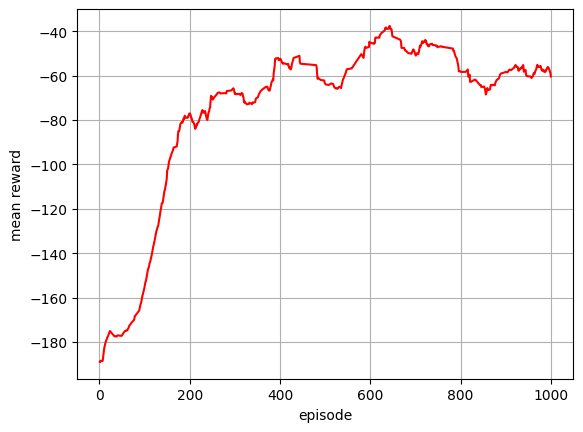

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(record_episode, record_reward, color="red")
plt.grid()
plt.xlabel("episode")
plt.ylabel("mean reward")
plt.savefig("./q-learning_episode_per_reward.png")
plt.show()
plt.clf()
plt.close()

グラフのダウンロード

In [11]:
from google.colab import files
files.download("./q-learning_episode_per_reward.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 学習結果を可視化
Q学習を用いて学習したエージェントを確認してみます．\
ここでは，学習時と同様の処理を行い，Gym-Notebook-Wrapper (gnwrapper)を用いて学習済みエージェントによるゲームプレイを可視化します．
学習時と異なるのは，$\epsilon$-greedy法は用いず常にQ値が最も高い行動を選択します．
指定したステップ数，フレームを獲得したら終了します．

In [12]:
import gnwrapper

env = gnwrapper.Monitor(env,directory="./") # 環境の作成

done = False
t = 0
observation = env.reset(seed=seed)
state = digitize_state(observation)
action = np.argmax(q_table[state])
while not done and t < 200:
    observation, reward, done, info = env.step(action)

    state = digitize_state(observation)
    action = np.argmax(q_table[state])
    t += 1

env.display()

/usr/local/lib/python3.12/dist-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:341: DeprecationWarning: Use shutil.which instead of find_executable
  if distutils.spawn.find_executable("avconv") is not None:
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent dat

'rl-video-episode-0.mp4'

# Q-Network
Q-Networkは，Q学習にニューラルネットワークの技術を適用した手法です．\
Q学習では，状態・行動数に合わせたQ-tableを作成し，TD法を用いたQ値の更新を行うことで，最適なQ-tableを作成する手法でした．
しかし，CartPoleのような状態数が連続的な値の場合，Q-tableが作成可能となるように，状態数の離散化を行わなければいけないという問題がありました．
そこで，Q-Networkではニューラルネットワークを用いた写像関数によって，Q-tableを表現することで，連続的な状態でも直接入力として使用可能としています．
ネットワークの出力を各行動に対応するのQ値を出力するように設計し，損失関数を用いた学習により最適なQ関数を近似します．

## 環境の作成
Q学習と同様に環境の作成を行います．（OpenAI gymのCartPole）

In [13]:
env = gym.make('CartPole-v1')

## ネットワークモデル
ネットワークの設計を行います．
今回は，全結合層が2層で構成されるネットワークとします．\
入力には，CartPoleにおけるCart位置，Cart速度，Poleの角度，Poleの角速度の4次元の情報を直接入力とします．
出力には，各行動ごとのQ値を出力するため，出力層はactionの数として定義します．

In [14]:
class QNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(QNetwork, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

## アクション選択
アクションの選択方法として$\epsilon$-greedy法を用いた行動選択の定義を行います．\
Q学習と同様に適度な探索を行うため，$\epsilon$-greedy法を用いて行動を選択します．
確率$\epsilon$で，ネットワークが出力したQ値が最も大きい行動を選択し，確率$1-\epsilon$でランダムな行動を選択します．

In [15]:
def get_action_qn(next_state, net, episode, epsilon):
    if epsilon <= np.random.uniform(0, 1):
        state_a = np.array([next_state], copy=None)
        state_v = torch.tensor(state_a).float()
        if use_cuda:
          state_v = state_v.cuda()
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        next_action = int(act_v.item())
    else:
        next_action = np.random.choice([0, 1])

    return next_action

## 損失関数の計算
ネットワークを更新するための損失関数の定義を行います．\
Q-Networkでは，ニューラルネットワークで最適なQ関数を近似します．
ニューラルネットワークを用いた学習のため損失関数を設計し，逆伝搬によりネットワークのパラメータを更新していきます．
損失関数は，Q学習の更新式をもとに設計されていて，以下のような二乗誤差になります．

$$
L_{\theta}=(r+\gamma \max_{a'}Q_{\theta}(s',a')-Q_{\theta}(s,a))^{2}
$$


In [16]:
def calc_loss(batch, net):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).float()
    next_states_v = torch.tensor(next_states).float()
    actions_v = torch.tensor(actions)
    rewards_v = torch.tensor(rewards)
    done_mask = torch.BoolTensor(dones)

    if use_cuda:
      states_v = states_v.cuda()
      next_states_v = next_states_v.cuda()
      actions_v = actions_v.cuda()
      rewards_v = rewards_v.cuda()
      done_mask = done_mask.cuda()

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = rewards_v + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_state_action_values)

## バッチ処理のためのbuffer
バッチ学習のために経験を収納，取り出す関数を定義します．

In [17]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class Buffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in range(batch_size)])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=bool), np.array(next_states)

## 学習に必要な各種パラメータ設定
今回の実験に使用する各種パラメータの設定を行います．
ここでは，総試行回数などの学習に必要なパラメータの設定を行っています．
また，ネットワークの定義や最適化手法を指定しています．
今回の実験では，最適化手法はAdamとしています．

In [18]:
max_number_of_steps = 200  # 1試行のstep数
num_consecutive_iterations = 100  # 学習完了評価に使用する平均試行回数
num_episodes = 1000  # 総試行回数

total_reward_vec = np.array([])  # 各試行の報酬を格納

LEARNING_RATE = 1e-4 # 学習率
GAMMA = 0.99 # 割引率
EPSILON = 0.02 # ε-greedy法のε

batch_size = 32 # バッチサイズ
train_num = 0

net = QNetwork(env.observation_space.shape[0], env.action_space.n)
if use_cuda:
  net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
buffer = Buffer(batch_size)

## 学習のメイン関数
Q-Networkのメイン関数です．
ここまでの設定に従い，Q-Newtworkの学習を行います．
以下のような流れのプログラムを作成します．
1. 環境を初期化し，初期状態を獲得
2. 獲得した初期状態から行動を選択（$\epsilon$-greedy法を用いた行動選択）
3. 環境に対してエージェントが行動（遷移情報の獲得）
4. バッチ数，経験を獲得したら損失関数の計算
5. 誤差逆伝播法を用いてネットワークの更新
6. 指定したステップ数，2～5を繰り返す

In [19]:
# グラフ描画用の配列
record_episode = []
record_reward = []

ts = time.time()
for episode in range(num_episodes):  # 試行数分繰り返す
    # 環境の初期化
    observation = env.reset(seed=seed)
    state = observation
    episode_reward = 0

    for t in range(max_number_of_steps):  # 1試行のループ
        action = get_action_qn(observation, net, episode, EPSILON) # 行動の選択

        observation, reward, done, info = env.step(action)
        next_state = observation

        # 報酬設計
        if done:
            if t < 195:
                reward = -200  # 倒れたら罰則
            else:
                reward = 1  # 立ったまま終了時は罰則はなし
        else:
            reward = 1  # 各ステップで立ってたら報酬追加

        episode_reward += reward  # 報酬を追加

        exp = Experience(state, action, reward, done, next_state)
        buffer.append(exp)
        state = next_state

        if train_num > batch_size:
            optimizer.zero_grad()
            batch = buffer.sample(batch_size)
            loss_t = calc_loss(batch, net)
            loss_t.backward()
            optimizer.step()

        train_num += 1

        # 終了時の処理
        if done:
            total_reward_vec = np.append(total_reward_vec, episode_reward)  # 報酬を記録
            record_reward.append(total_reward_vec[-100:].mean()) # グラフ描画用に記録
            record_episode.append(episode+1)
            if (episode+1)%10==0:
              print('Episode {0}: {1} steps, reward {2}, mean reward {3:.3f}, time {4}'.format(episode+1, t+1, episode_reward, total_reward_vec[-100:].mean(), datetime.timedelta(seconds = time.time() - ts)))
            break

Episode 10: 27 steps, reward -174, mean reward -189.300, time 0:00:01.099934
Episode 20: 48 steps, reward -153, mean reward -183.500, time 0:00:01.833999
Episode 30: 16 steps, reward -185, mean reward -184.533, time 0:00:02.252843
Episode 40: 14 steps, reward -187, mean reward -183.900, time 0:00:02.856854
Episode 50: 10 steps, reward -191, mean reward -184.880, time 0:00:03.205404
Episode 60: 9 steps, reward -192, mean reward -184.700, time 0:00:03.840201
Episode 70: 14 steps, reward -187, mean reward -185.486, time 0:00:04.336443
Episode 80: 9 steps, reward -192, mean reward -186.200, time 0:00:04.677326
Episode 90: 10 steps, reward -191, mean reward -186.244, time 0:00:05.130938
Episode 100: 10 steps, reward -191, mean reward -183.500, time 0:00:06.562182
Episode 110: 14 steps, reward -187, mean reward -183.180, time 0:00:06.975224
Episode 120: 15 steps, reward -186, mean reward -183.630, time 0:00:07.847648
Episode 130: 18 steps, reward -183, mean reward -183.370, time 0:00:09.2686

## 学習時の平均スコアの推移
横軸エピソード数，縦軸平均スコアとしたグラフを描画してみます．


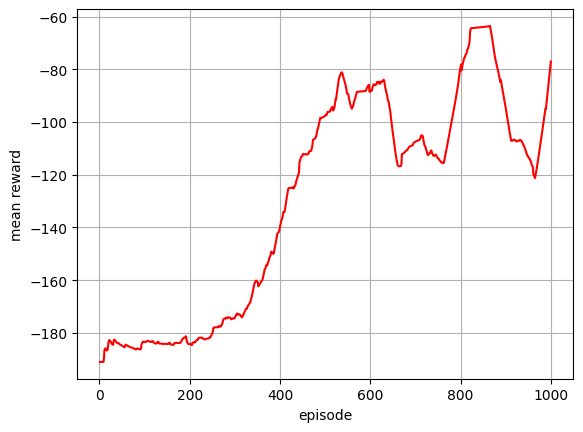

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(record_episode, record_reward, color="red")
plt.grid()
plt.xlabel("episode")
plt.ylabel("mean reward")
plt.savefig("./q-network_episode_per_reward.png")
plt.show()
plt.clf()
plt.close()

In [21]:
from google.colab import files

files.download("./q-network_episode_per_reward.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 学習結果を可視化
学習したネットワーク（エージェント）を確認してみます．\
ここでは，学習時と同様の処理を行い，Gym-Notebook-Wrapper (gnwrapper)を用いて学習済みエージェントによるゲームプレイを可視化します．
学習時と異なるのは，$\epsilon$-greedy法は用いず，常にQ値が最も高い行動を選択します．
指定したステップ数，フレームを獲得したら終了します．

In [22]:
import gnwrapper

env = gnwrapper.Monitor(env,directory="./") # 環境の作成

done = False
t = 0
state = env.reset(seed=seed)

while not done and t < 200:
  state_a = np.array([state], copy=None)
  state_v = torch.tensor(state_a).float()
  if use_cuda:
    state_v = state_v.cuda()
  q_vals_v = net(state_v)
  _, act_v = torch.max(q_vals_v, dim=1)
  action = int(act_v.item())

  new_state, reward, done, info = env.step(action)
  state = new_state
  t += 1

env.display()

/usr/local/lib/python3.12/dist-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:341: DeprecationWarning: Use shutil.which instead of find_executable
  if distutils.spawn.find_executable("avconv") is not None:
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/usr/

'rl-video-episode-0.mp4'

# 課題

1. Q-tableを用いた学習方法において，テーブルを作成する際の「状態の分割数」を変えて実験してみましょう．

2. 強化学習特有のパラメータを変えて実験してみましょう．
  * 強化学習特有のパラメータとして，割引率 `GAMMA` や$\epsilon$-greedy法の`EPSILON`があります．

3. 報酬の値を変更して実験してみましょう．
 * Q-Tableを用いる学習の場合は「Q学習メインプログラム」内の報酬設計，Q-Networkの場合は「学習のメイン関数」の報酬設計にある報酬の値を変更します．